Dataset: https://github.com/balajisrinivas/Face-Mask-Detection/tree/master/dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/MaskNet

/content/drive/MyDrive/MaskNet


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imutils import paths

# Loading Image Data and labels for each class

In [ ]:
dir = r'Data'
classes = ['wo_mask', 'w_mask']

images = []
labels = []

for cls in classes:
    path = os.path.join(dir, cls)
    for image in os.listdir(path):
    	image_path = os.path.join(path, image)
    	image = load_img(image_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	images.append(image)
    	labels.append(cls)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
for i in range(len(labels)):
  if(labels[i] == 'wo_mask'):
    labels[i] = 0
  else:
    labels[i] = 1

In [ ]:
images = np.array(images, dtype = 'float32')
labels = np.array(labels)

In [ ]:
print(images.shape) 
print(labels.shape)

(3833, 224, 224, 3)
(3833,)


# Splitting data into Train and Test in a Stratified fashion

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(images, labels,	test_size = 0.2, stratify = labels, random_state = 42)

In [ ]:
print(X_train.shape)
print(Y_train.shape) 
print(X_test.shape)
print(Y_test.shape)

(3066, 224, 224, 3)
(3066,)
(767, 224, 224, 3)
(767,)


# Image Data Generator for Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20, 
    zoom_range=0.15,	
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
	  horizontal_flip=True,
	  fill_mode="nearest")

# Creating the Model using Transfer Learning


### Using the MobileNetV2 CNN Architecture
1. ImageNet pre-trained weights are being used.
2. FC layer sets are not being used, custom FC layers will be developed later. 

In [ ]:
#Base Model
mnv2 = MobileNetV2(weights="imagenet", include_top=False, input_shape = (224, 224, 3))

9420800/9406464 [==============================] - 0s 0us/step


###Creating the custom layers on top of MobileNetV2

In [ ]:
#Head Model
custom_model = mnv2.output
custom_model = AveragePooling2D(pool_size=(7, 7))(custom_model)
custom_model = Flatten(name="flatten")(custom_model)
custom_model = Dense(128, activation="relu")(custom_model)
custom_model = Dropout(0.5)(custom_model)
custom_model = Dense(1, activation="sigmoid")(custom_model)

In [ ]:
model = Model(inputs=mnv2.input, outputs=custom_model)

###Freezing all the layers in MobileNetV2 so that they don't update during the training process and information contained in them is thus preserved

In [ ]:
for layer in mnv2.layers:
	layer.trainable = False

###Compiling the Model

In [ ]:
learning_rate = 1e-4
epochs = 20
batch_size = 32

In [ ]:
optimizer = Adam(learning_rate = learning_rate, decay = learning_rate/epochs)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

###Training the Model

In [ ]:
history = model.fit(
    datagen.flow(X_train, Y_train, batch_size = batch_size), 
    steps_per_epoch = len(X_train) // batch_size, 
    validation_data = (X_test, Y_test), 
    validation_steps = len(X_test) // batch_size,
	  epochs = epochs)

Epoch 1/20
95/95 [==============================] - 70s 608ms/step - loss: 0.3620 - accuracy: 0.8398 - val_loss: 0.1252 - val_accuracy: 0.9726
Epoch 2/20
95/95 [==============================] - 50s 524ms/step - loss: 0.1150 - accuracy: 0.9677 - val_loss: 0.0762 - val_accuracy: 0.9804
Epoch 3/20
95/95 [==============================] - 48s 508ms/step - loss: 0.0816 - accuracy: 0.9769 - val_loss: 0.0517 - val_accuracy: 0.9857
Epoch 4/20
95/95 [==============================] - 41s 430ms/step - loss: 0.0739 - accuracy: 0.9733 - val_loss: 0.0514 - val_accuracy: 0.9844
Epoch 5/20
95/95 [==============================] - 43s 451ms/step - loss: 0.0577 - accuracy: 0.9825 - val_loss: 0.0468 - val_accuracy: 0.9844
Epoch 6/20
95/95 [==============================] - 46s 487ms/step - loss: 0.0497 - accuracy: 0.9848 - val_loss: 0.0381 - val_accuracy: 0.9870
Epoch 7/20
95/95 [==============================] - 40s 418ms/step - loss: 0.0467 - accuracy: 0.9855 - val_loss: 0.0400 - val_accuracy: 0.9844

#Evaluating the Model

In [ ]:
loss, accuracy = model.evaluate(X_test, Y_test, batch_size = batch_size)
print(f"Accuracy on Test Data: {'%.2f' %(accuracy * 100)}%")
print(f'Loss on Test Data: {loss}')

24/24 [==============================] - 2s 90ms/step - loss: 0.0272 - accuracy: 0.9909
Accuracy on Test Data: 99.09%
Loss on Test Data: 0.02716529741883278


In [ ]:
Y_predictions = model.predict(X_test, batch_size=batch_size)
Y_predictions = tf.greater(Y_predictions, .5)

In [ ]:
print('Classification Report:')
print(classification_report(Y_test, Y_predictions, target_names=['Without Mask', 'With Mask']))
print('-----------------------------------------------------')
print('Confusion Matrix:')
print(confusion_matrix(Y_test, Y_predictions))

Classification Report:
              precision    recall  f1-score   support

Without Mask       1.00      0.98      0.99       384
   With Mask       0.98      1.00      0.99       383

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767

-----------------------------------------------------
Confusion Matrix:
[[377   7]
 [  0 383]]


#Plotting the Model Accuracy and Loss on Training and Validation Sets

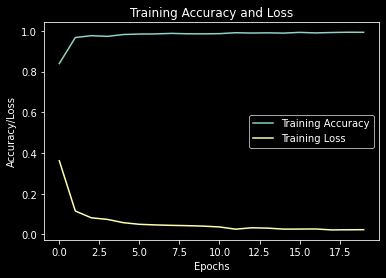

In [ ]:
plt.style.use('dark_background')
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Accuracy and Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend(loc='best')
plt.savefig('Training Plot.png')
plt.show()

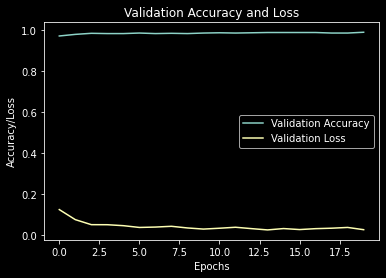

In [ ]:
plt.style.use('dark_background')
plt.figure()
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Validation Accuracy and Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend(loc='best')
plt.savefig('Validation Plot.png')
plt.show()

#Saving the Model so that it can be used in real-time applications

In [ ]:
model.save('MaskNet.model', save_format='h5')